## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

# build mlp with batch normalization
def build_mlp(input_shape, regular_dict, drp_ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    if 'l1' in regular_dict:
        kernel_regularizer = l1(regular_dict.get('l1'))
    elif 'l2' in regular_dict:
        kernel_regularizer = l2(regular_dict.get('l2'))
    else:
        print('Error Regular dict')
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=kernel_regularizer)(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## Hyper param setting 
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 256
MOMENTUM = 0.95
regular_type_list = ['l1', 'l2']
regular_ratio = [1e-2, 1e-4, 1e-8, 1e-12]
drp_ratio_list = [0.1, 0.2, 0.3]

In [7]:
results = {}

for regular_type in regular_type_list:
    for r in regular_ratio:
        for drp_ratio in drp_ratio_list:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print(f"Experiment {regular_type} with Regulizer {r} and drop_ratio: {drp_ratio}")
            model = build_mlp(input_shape=x_train.shape[1:], regular_dict={regular_type: r}, drp_ratio=drp_ratio)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]

            exp_name_tag = f"exp-{regular_type}-{r}-d_ratio-{drp_ratio}"
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

Experiment l1 with Regulizer 0.01 and drop_ratio: 0.1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 15s 309us/step - loss: 6.0860 - accuracy: 0.2898 - val_loss: 5.7265 - val_accuracy: 0.3856
Epoch 2/3
50000/50000 [==============================] - 15s 293us/step - loss: 5.6790 - accuracy: 0.3743 - val_loss: 5.5294 - val_accuracy: 0.4124
Epoch 3/3
50000/50000 [==============================] - 15s 293us/step - loss: 5.5134 - accuracy: 0.4080 - val_loss: 5.4346 - val_accuracy: 0.4203
Experiment l1 with Regulizer 0.0001 and drop_ratio: 0.2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 17s 340us/step - loss: 2.2462 - accuracy: 0.2475 - val_loss: 1.8472 - val_accuracy: 0.3409
Epoch 2/3
50000/50000 [==============================] - 16s 317us/step - loss: 1.8883 - accuracy: 0.3347 - val_loss: 1.6859 - val_accuracy: 0.4041
Epoch 3/3
50000/50000 [==============================] - 16s 316us/step - loss: 1.7868 - accuracy: 0.3631 - val_loss: 1.6623 - val_accuracy: 0.4008
Experiment l1 with Regulizer 1e-08 and drop_ratio: 0.3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 51

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 19s 384us/step - loss: 2.4084 - accuracy: 0.2141 - val_loss: 1.8607 - val_accuracy: 0.3326
Epoch 2/3
50000/50000 [==============================] - 25s 491us/step - loss: 2.0345 - accuracy: 0.2883 - val_loss: 1.7795 - val_accuracy: 0.3623
Epoch 3/3
50000/50000 [==============================] - 22s 446us/step - loss: 1.9051 - accuracy: 0.3195 - val_loss: 1.7133 - val_accuracy: 0.3810
Experiment l2 with Regulizer 0.01 and drop_ratio: 0.1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 322us/step - loss: 2.2421 - accuracy: 0.2890 - val_loss: 1.9264 - val_accuracy: 0.3679
Epoch 2/3
50000/50000 [==============================] - 17s 343us/step - loss: 1.9015 - accuracy: 0.3748 - val_loss: 1.7725 - val_accuracy: 0.4181
Epoch 3/3
50000/50000 [==============================] - 16s 319us/step - loss: 1.8075 - accuracy: 0.4068 - val_loss: 1.7057 - val_accuracy: 0.4400
Experiment l2 with Regulizer 0.0001 and drop_ratio: 0.2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 24s 483us/step - loss: 2.2581 - accuracy: 0.2470 - val_loss: 1.8651 - val_accuracy: 0.3344
Epoch 2/3
50000/50000 [==============================] - 16s 330us/step - loss: 1.9057 - accuracy: 0.3284 - val_loss: 1.7185 - val_accuracy: 0.3771
Epoch 3/3
50000/50000 [==============================] - 17s 332us/step - loss: 1.7937 - accuracy: 0.3595 - val_loss: 1.6685 - val_accuracy: 0.3993
Experiment l2 with Regulizer 1e-08 and drop_ratio: 0.3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 51

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 20s 404us/step - loss: 2.4036 - accuracy: 0.2176 - val_loss: 1.8781 - val_accuracy: 0.3362
Epoch 2/3
50000/50000 [==============================] - 19s 387us/step - loss: 2.0225 - accuracy: 0.2908 - val_loss: 1.7819 - val_accuracy: 0.3562
Epoch 3/3
50000/50000 [==============================] - 19s 384us/step - loss: 1.8938 - accuracy: 0.3219 - val_loss: 1.6945 - val_accuracy: 0.3915


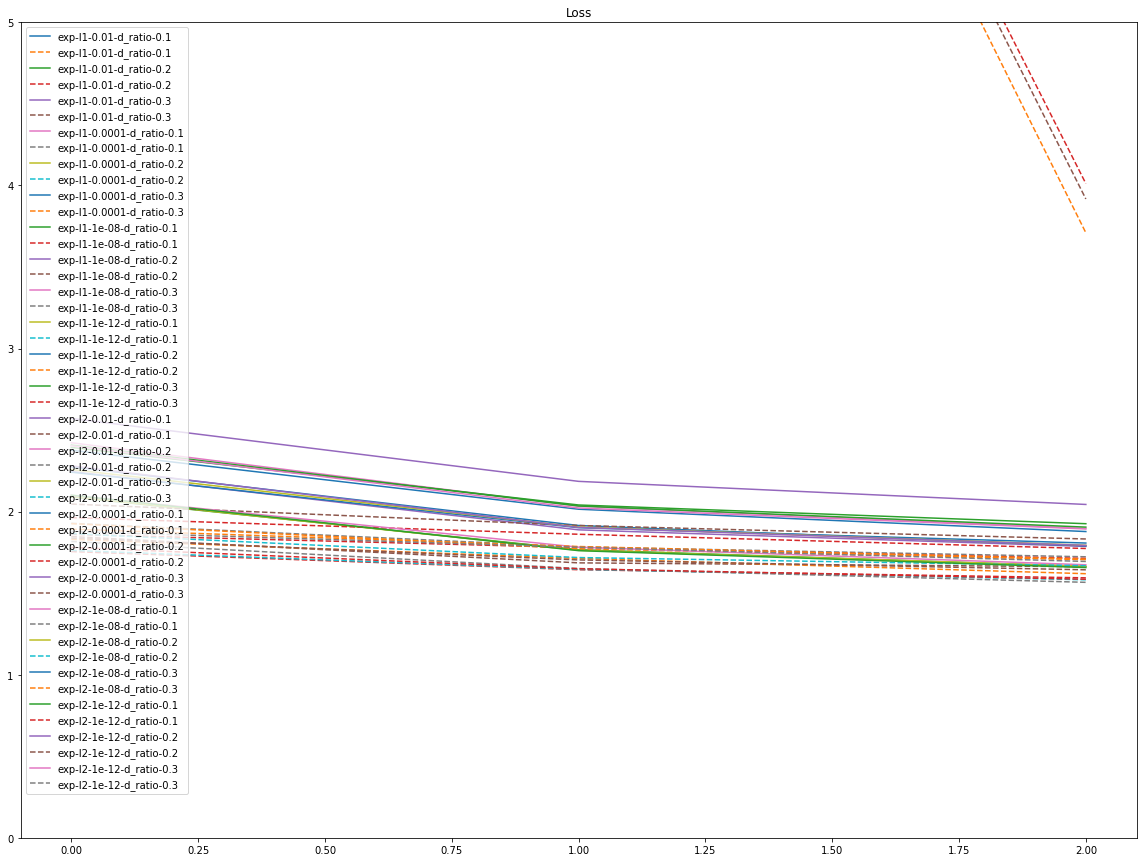

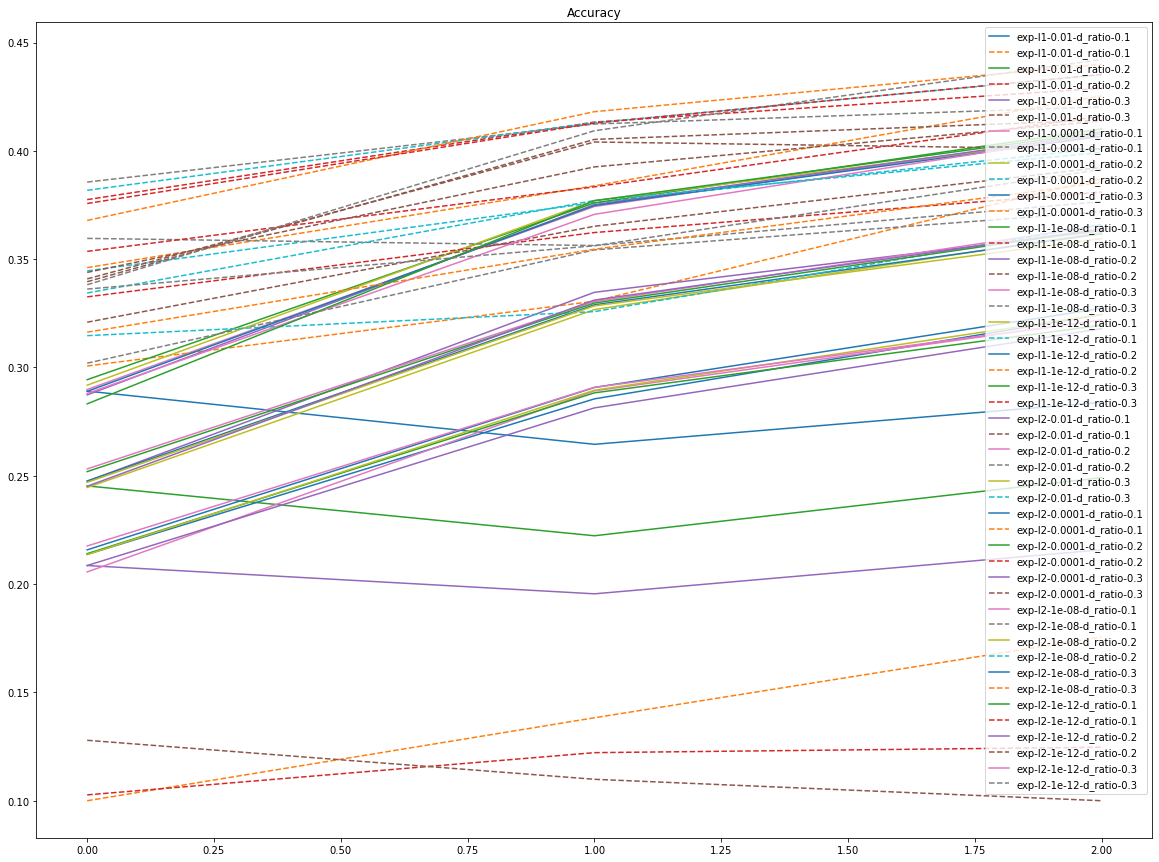

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(20,15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
plt.title("Accuracy")
plt.legend()
plt.show()